In [12]:
import pandas as pd
import numpy as np
from itertools import product

import oracles
import optimization
from optimization import gradient_descent, hessian_free_newton, lbfgs

Загрузим данные

In [13]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/news20.binary.bz2
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/rcv1_train.binary.bz2
!bzip2 -d gisette_scale.bz2
!bzip2 -d real-sim.bz2
!bzip2 -d news20.binary.bz2
!bzip2 -d rcv1_train.binary.bz2

--2022-03-13 17:50:06--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3478238 (3.3M)
Saving to: ‘w8a.1’

w8a.1               100%[===================>]   3.32M  2.62MB/s    in 1.3s    

2022-03-13 17:50:09 (2.62 MB/s) - ‘w8a.1’ saved [3478238/3478238]

--2022-03-13 17:50:09--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21902461 (21M) [application/x-bzip2]
Saving to: ‘gisette_scale.bz2’

gisette_scale.bz2   100%[===================>]  20.89M  8.32MB/s    in 2.5s    

2022-03-13 17:50:12 (8.32 MB/s) - ‘gisette_

In [14]:
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

data = ["w8a", "gisette_scale", "real-sim", "news20.binary", "rcv1_train.binary"]

@mem.cache
def get_data(name):
    data = load_svmlight_file(name)
    return data[0], data[1]

for d in data:
    X, y = get_data(d)
    display(X)

<49749x300 sparse matrix of type '<class 'numpy.float64'>'
	with 579586 stored elements in Compressed Sparse Row format>

<6000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 29729997 stored elements in Compressed Sparse Row format>

<72309x20958 sparse matrix of type '<class 'numpy.float64'>'
	with 3709083 stored elements in Compressed Sparse Row format>

<19996x1355191 sparse matrix of type '<class 'numpy.float64'>'
	with 9097916 stored elements in Compressed Sparse Row format>

<20242x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 1498952 stored elements in Compressed Sparse Row format>

In [15]:
for d in data:
    X, y = get_data(d)
    print(d, ": ", X.shape, sep='')

w8a: (49749, 300)
gisette_scale: (6000, 5000)
real-sim: (72309, 20958)
news20.binary: (19996, 1355191)
rcv1_train.binary: (20242, 47236)


Функция для рисования графиков

In [16]:
import matplotlib.pyplot as plt 

def process(X, y, dataset):
  if dataset == "rcv1_train.binary":
    dataset = "rcv1"
  if dataset == "news20.binary":
    dataset = "news20"
  colors=['green', 'purple', 'blue']
  oracle = oracles.create_log_reg_oracle(X, y, 1. / X.shape[1])
  x_0 = np.zeros(X.shape[1])
  history = gradient_descent(oracle, x_0, trace=True)[2]
  history1 = hessian_free_newton(oracle, x_0, trace=True)[2]
  history2 = lbfgs(oracle, x_0, trace=True)[2]
    
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.plot(history['func'], label="Градиентный спуск", color=colors[0])
  ax.plot(history1['func'], label="Усеченный метод Ньютона", color=colors[1])
  ax.plot(history2['func'], label="l-bfgs", color=colors[2])
  lab = 'Значение функции против номера итерации, данные ' + str(dataset)
  plt.xlabel('Итерация', fontsize=15)
  plt.ylabel('Значение функции', fontsize=15)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.title(lab, fontsize=15)

  ax.legend(fontsize=15)
  ax.grid()
  name = "func-iter" + str(dataset)
  plt.savefig(name, bbox_inches="tight")
  plt.show()

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.plot(history['time'], history['func'], label="Градиентный спуск", color=colors[0])
  ax.plot(history1['time'], history1['func'], label="Усеченный метод Ньютона", color=colors[1])
  ax.plot(history2['time'], history2['func'], label="l-bfgs", color=colors[2])

  lab = 'Значение функции против реального времени работы' 
  plt.xlabel('Время (секунды)', fontsize=15)
  plt.ylabel('Значение функции', fontsize=15)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(lab, fontsize=15)

  ax.legend(fontsize=15)
  ax.grid()
  name = "func-time" + str(dataset)
  plt.savefig(name, bbox_inches="tight")
  plt.show()

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.plot(history['time'], (history['grad_norm'] / history['grad_norm'][0])**2, 
            label="Градиентный спуск", color=colors[0])
    
  ax.plot(history1['time'], (history1['grad_norm'] / history1['grad_norm'][0])**2, 
            label="Усеченный метод Ньютона", color=colors[1]) 
  
  ax.plot(history2['time'], (history2['grad_norm'] / history2['grad_norm'][0])**2, 
            label="l-bfgs", color=colors[2]) 
       
  lab = 'Относительный квадрат нормы против реального времени работы'
  plt.xlabel('Время (секунды)', fontsize=15)
  plt.xlabel('Время (секунды)', fontsize=15)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.ylabel('Логарифм относительного квадрата нормы', fontsize=15)
  plt.yscale('log')
  plt.title(lab, fontsize=15)

  ax.legend(fontsize=15)
  ax.grid()
  name = "norm " + str(dataset)
  plt.savefig(name, bbox_inches="tight")
  plt.show()

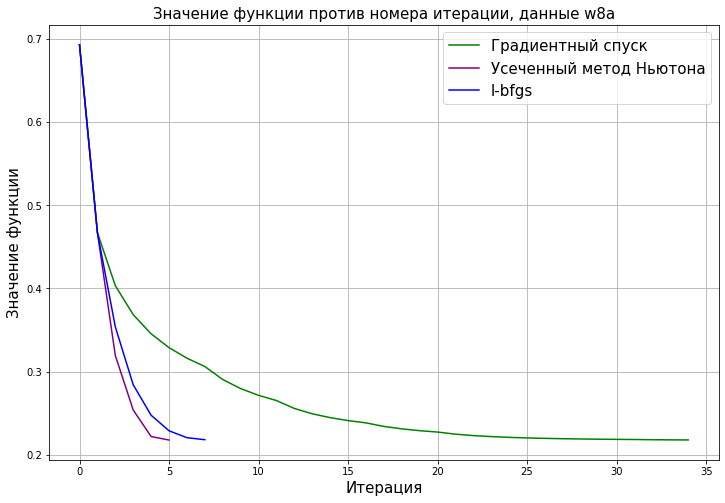

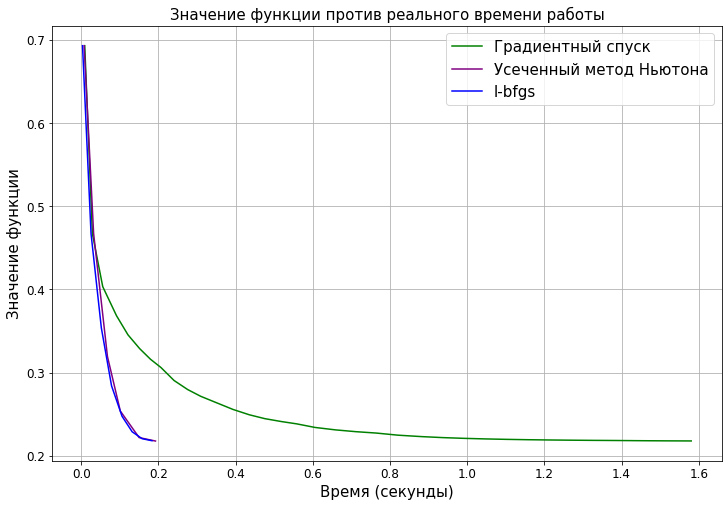

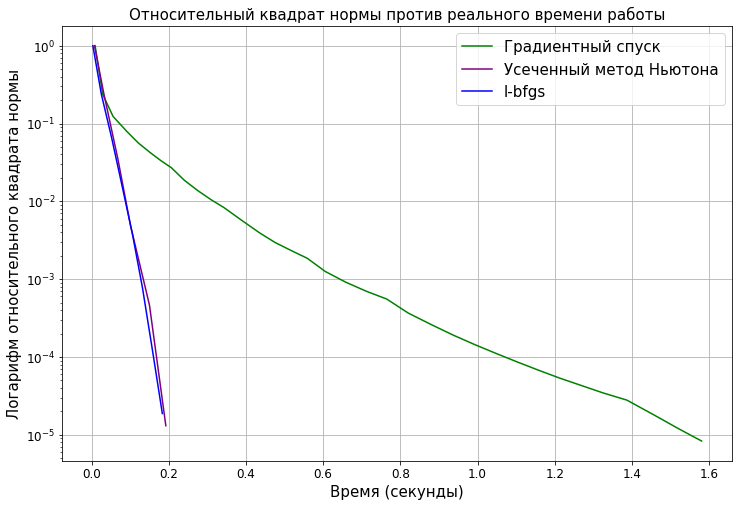

In [17]:
X, y = get_data("w8a")
process(X, y, "w8a")

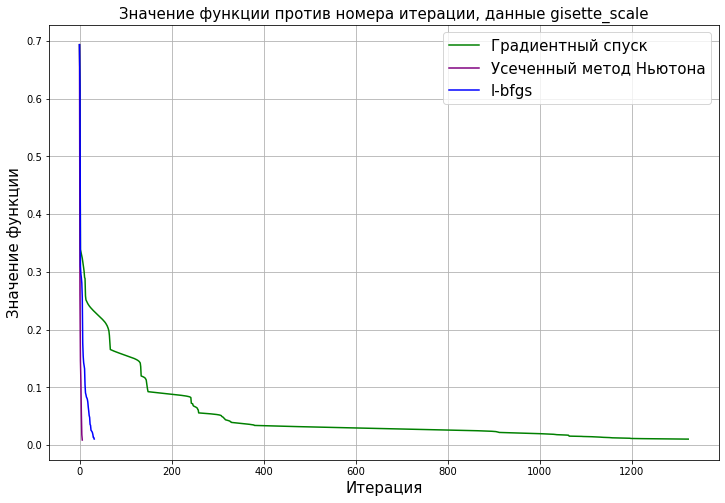

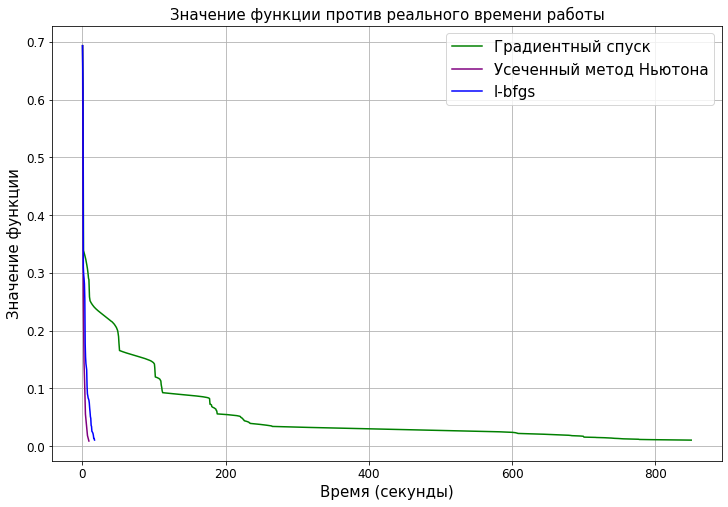

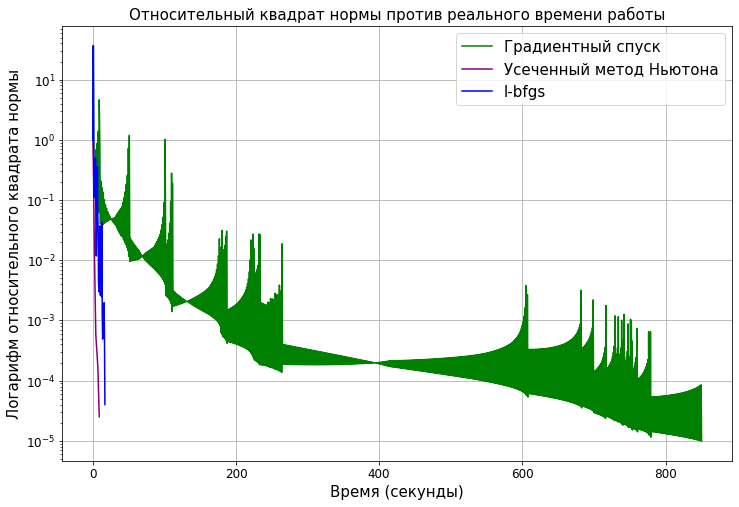

In [18]:
X, y = get_data("gisette_scale")
process(X, y, "gisette_scale")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


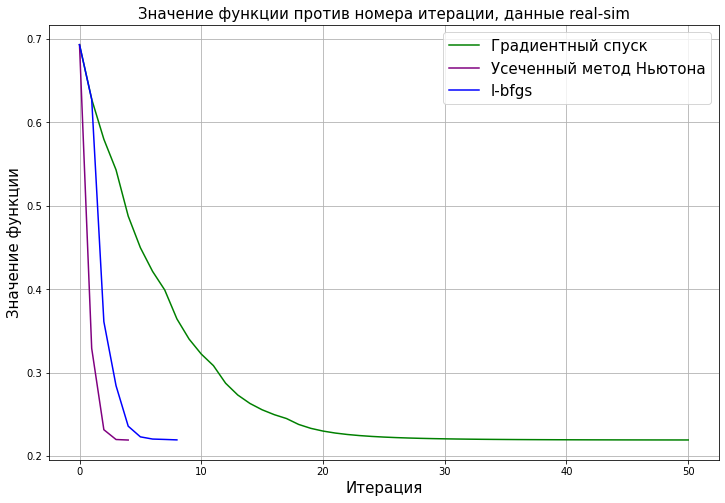

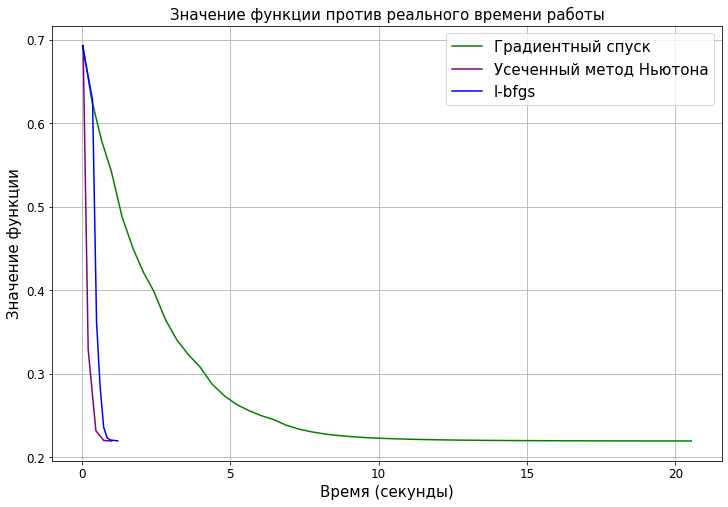

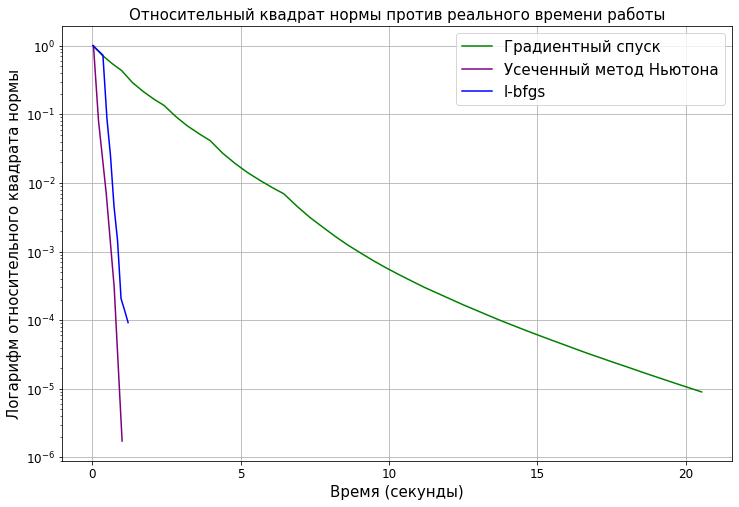

In [19]:
X, y = get_data("real-sim")
process(X, y, "real-sim")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


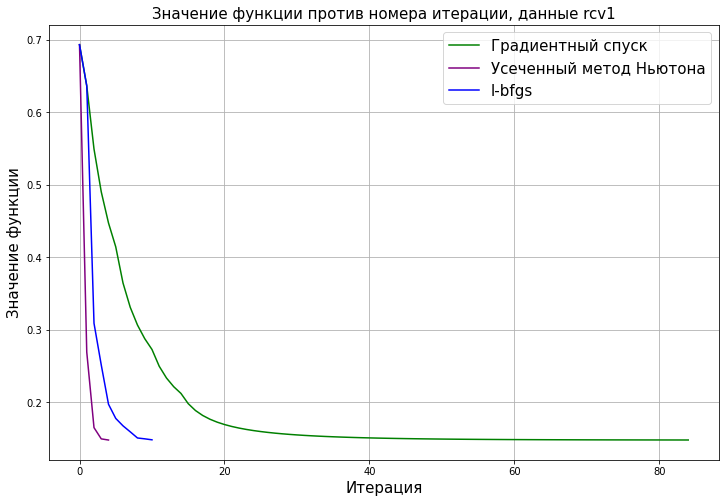

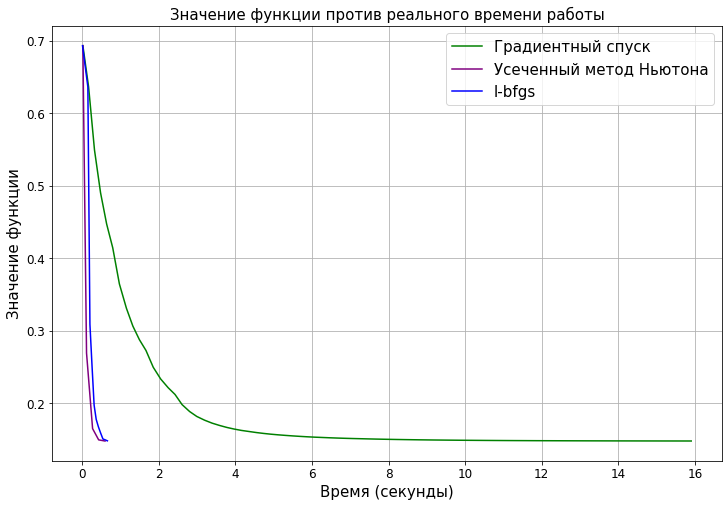

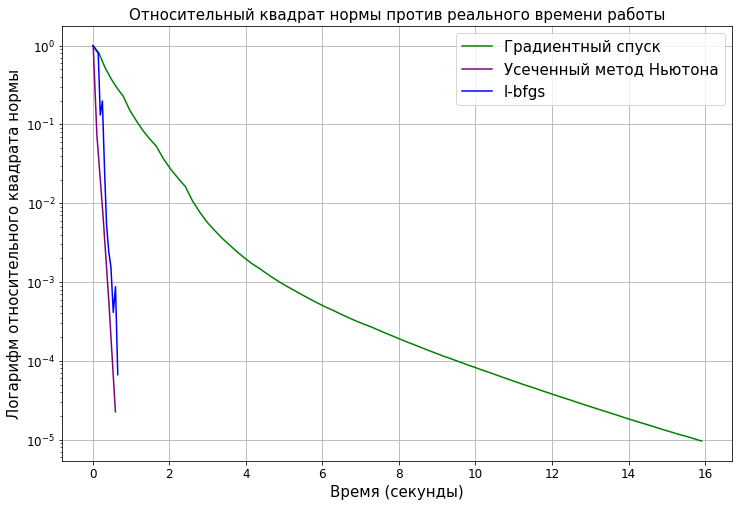

In [20]:
X, y = get_data("rcv1_train.binary")
process(X, y, "rcv1_train.binary")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


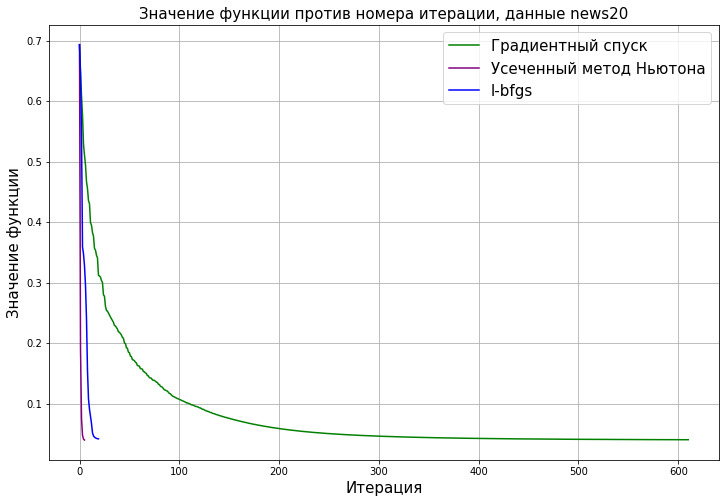

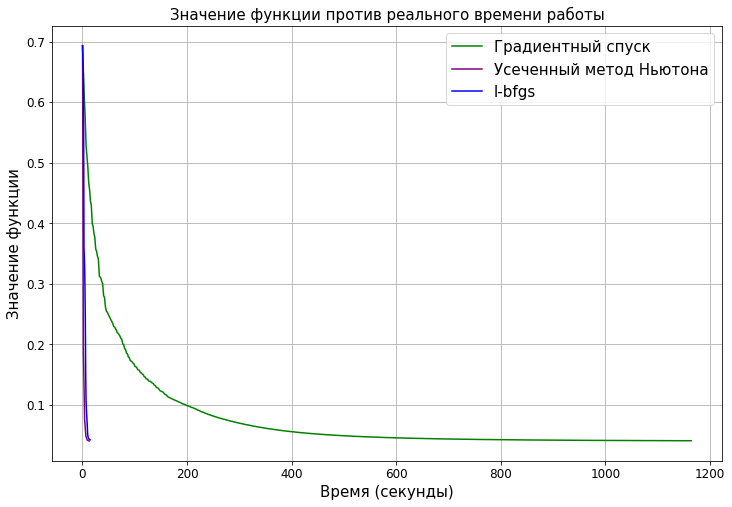

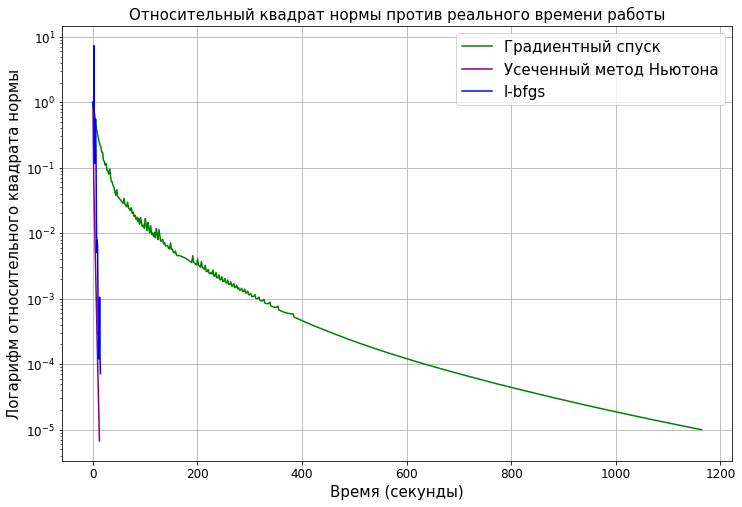

In [21]:
X, y = get_data("news20.binary")
process(X, y, "news20.binary")